In [21]:
import cv2

import pandas as pd
import numpy as np
import xml.etree.cElementTree as ET

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import matplotlib.pylab as plt
%matplotlib inline

In [22]:
def xml_content_to_dataframe(xml_file: str) -> pd.DataFrame:

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text
        name = boxes.find("name").text

        ymin, xmin, ymax, xmax = None, None, None, None


        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [name, xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

        df = GeoDataFrame(list_with_all_boxes, columns=["name", "xmin", "ymin", "xmax", "ymax"])
        
    return df

def draw_boundingbox_from_daraframe(image, dataframe):

    img = image.copy()
 
    for row in dataframe.itertuples():

        label = row.name

        ymin = row.ymin
        xmin = row.xmin
        ymax = row.ymax
        xmax=row.xmax        
  
        img = cv2.rectangle(
            img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 5
        )

    return img 

class Rect:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    
    def bottom(self):
        return self.y + self.h
    
    def right(self):
        return self.x + self.w
    
    def area(self):
        return self.w * self.h
    
    def center(self):
        return self.w/2, self.h/2
    
    def union(self, b):
        posX = min(self.x, b.x)
        posY = min(self.y, b.y)
        
        return Rect(posX, posY, max(self.right(), b.right()) - posX, max(self.bottom(), b.bottom()) - posY)
    
    def intersection(self, b):
        posX = max(self.x, b.x)
        posY = max(self.y, b.y)
        
        candidate = Rect(posX, posY, min(self.right(), b.right()) - posX, min(self.bottom(), b.bottom()) - posY)
        if candidate.w > 0 and candidate.h > 0:
            return candidate
        return Rect(0, 0, 0, 0)
    
    def ratio(self, b):
        return self.intersection(b).area() / self.union(b).area()

In [23]:
def transform(df):
    df["centroid_x"] = (df["xmax"] + df["xmin"]) / 2
    df["centroid_y"] = (df["ymax"] + df["ymin"]) / 2
    return df

In [24]:
df0 = xml_content_to_dataframe("golden.xml")
df1 = xml_content_to_dataframe("input.xml")

In [25]:
df0 = transform(df0)
df1 =  transform(df1)

distance_cost_matrix = cdist(df0[["centroid_x", "centroid_y"]], df1[["centroid_x", "centroid_y"]])
cost_mat = np.log(distance_cost_matrix) #np.log(np.multiply(area_cost_matrix, distance_cost_matrix))

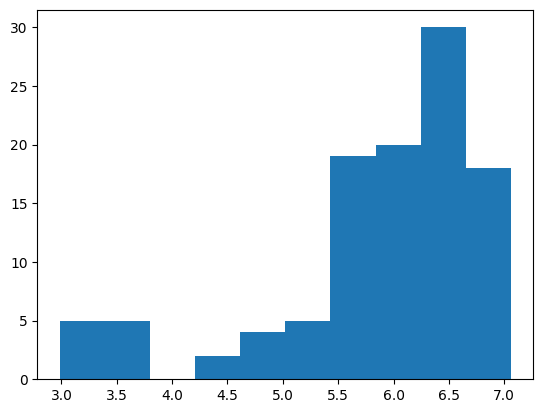

In [34]:
plt.hist(cost_mat.ravel())
plt.show() 

In [26]:
def pseudo_inf(cost_mat, inf_func):
    pseudo_inf_val = inf_func(cost_mat[cost_mat != np.inf])
    pseudo_cost_mat = cost_mat.copy()
    pseudo_cost_mat[pseudo_cost_mat == np.inf] = pseudo_inf_val
    return pseudo_cost_mat, pseudo_inf_val

def get_costs(cost_mat, row_ind, col_ind):
    costs = [cost_mat[i, j] for i, j in zip(row_ind, col_ind)]
    return costs

def assign_detections_to_tracks(
        cost_mat,
        cost_of_non_assignment=None
    ):
    # in case there are infinite value, replace them by some pseudo infinite
    # values
    inf_func =  lambda x: np.max(x) * 2
    pseudo_cost_mat, pseudo_inf_val = pseudo_inf(cost_mat, inf_func)
    assigned_rows = []
    unassigned_rows = []
    assigned_cols = []
    unassigned_cols = []
    full_cost_mat = None
    # basic case, handled by linear_sum_assignment directly
    if cost_of_non_assignment is None:
        assigned_rows, assigned_cols = linear_sum_assignment(pseudo_cost_mat)
        assignment_costs = get_costs(cost_mat, assigned_rows, assigned_cols)
    # if one cost of non assignment is provided, use it
    else:
        # build the pseudo-array
        top_right_corner = np.full((cost_mat.shape[0], cost_mat.shape[0]), pseudo_inf_val)
        np.fill_diagonal(top_right_corner, cost_of_non_assignment)
        bottom_left_corner = np.full((cost_mat.shape[1], cost_mat.shape[1]), pseudo_inf_val)
        np.fill_diagonal(bottom_left_corner, cost_of_non_assignment)
        top = np.concatenate((cost_mat, top_right_corner), axis=1)
        zero_corner = np.full(cost_mat.T.shape, 0)
        # zero_corner = np.full(cost.shape,cost_of_non_assignment)
        bottom = np.concatenate((bottom_left_corner, zero_corner), axis=1)
        full_cost_mat = np.concatenate((top, bottom), axis=0)
        # apply linear assignment to pseudo array
        row_idxs, col_idxs = linear_sum_assignment(full_cost_mat)
        # get costs
        for row_idx, col_idx in zip(row_idxs, col_idxs):
            if row_idx < cost_mat.shape[0] and col_idx < cost_mat.shape[1]:
                assigned_rows.append(row_idx)
                assigned_cols.append(col_idx)
            elif row_idx < cost_mat.shape[0] and col_idx >= cost_mat.shape[1]:
                unassigned_rows.append(row_idx)
            elif col_idx < cost_mat.shape[1] and row_idx >= cost_mat.shape[0]:
                unassigned_cols.append(col_idx)
        #
        full_costs = get_costs(full_cost_mat, row_idxs, col_idxs)
        assignment_costs = get_costs(
            full_cost_mat, assigned_rows, assigned_cols)
    return assigned_rows, assigned_cols, unassigned_rows, unassigned_cols, full_cost_mat, assignment_costs

In [27]:
(
    assigned_rows,
    assigned_cols,
    unassigned_rows,
    unassigned_cols,
    full_costs,
    assignment_cost
) = assign_detections_to_tracks(cost_mat, cost_of_non_assignment=10)
unassigned_rows, unassigned_cols

([2, 7, 10], [])

In [28]:
df0.iloc[unassigned_rows, :]

,name,xmin,ymin,xmax,ymax,centroid_x,centroid_y
2,big fish,1080,484,1236,597,1158.0,540.5
7,small fish,684,505,732,535,708.0,520.0
10,small fish,743,598,792,642,767.5,620.0


In [29]:
input_image = cv2.imread(r"golden.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

In [30]:
missing_object_on_input_image = draw_boundingbox_from_daraframe(input_image, df0.iloc[unassigned_rows, :])

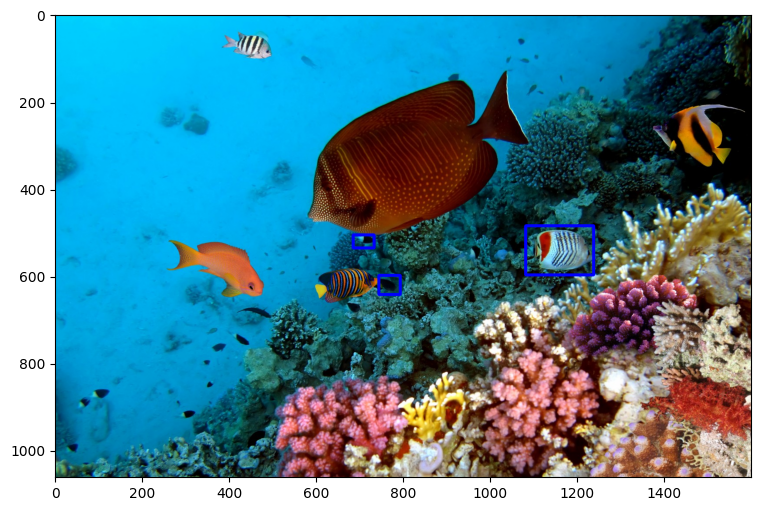

In [31]:
plt.figure(figsize=(20, 6))
plt.imshow(missing_object_on_input_image)
plt.show()